# SED Reconstruction Demo - Deep Image Prior (DIP) Version

This script demonstrates the **new Deep Image Prior (DIP)** reconstruction system for SPHEREx narrow-band photometry using PyTorch. 

## Deep Image Prior Overview

Instead of solving for pixel values directly, we optimize the weights of a **generative neural network (1D U-Net)** to map fixed random noise to the observed spectrum. This architectural prior inherently enforces local smoothness and correlation, eliminating Gibbs phenomena and providing global coherence across all bands.


## 1. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch

# Import SED reconstruction module
from spxquery.sed import (
    SEDConfig,
    SEDReconstructor,
    export_default_sed_config,
    reconstruct_sed_from_csv,
)
from spxquery.sed.data_loader import load_all_bands

# Check device availability
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Configure matplotlib for better plots
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 10

print("DIP-based SED reconstruction module imported successfully!")


Using device: mps
DIP-based SED reconstruction module imported successfully!


## 2. Configure Deep Spectral Prior Reconstruction
We configure the `SEDConfig` to use the PyTorch solver (`solver_type="torch"`) and set optimization parameters.

In [2]:
# Configure for Deep Spectral Prior
config_dip = SEDConfig(
    solver_type="torch",          # Use PyTorch solver
    device=device,                # Use GPU acceleration if available
    
    # Global Grid Settings
    wavelength_range=(0.75, 5.0), # Full spectral range
    global_resolution=3000,       # High-resolution grid
    
    # Optimization Parameters
    epochs=3000,                  # Number of iterations (DIP needs more epochs)
    learning_rate=0.001,          # Learning rate for Adam
    regularization_weight=1.0,    # Weight for CWT sparsity loss
    
    # Neural Network Architecture
    dip_filters=32,               # Base filters in U-Net
    dip_depth=3,                  # Depth of U-Net
    dip_noise_std=0.1,            # Input noise standard deviation
    
    # CWT Scales for Regularization
    cwt_scales=[1.0, 2.0, 3.0],   # Scales for Mexican Hat wavelets
    
    # Pre-processing
    sigma_threshold=3.0,
    enable_sigma_clip=True
)

print("DIP Configuration:")
print(f"  Solver: {config_dip.solver_type}")
print(f"  Resolution: {config_dip.global_resolution} pixels")
print(f"  Device: {config_dip.device}")
print(f"  Epochs: {config_dip.epochs}")

DIP Configuration:
  Solver: torch
  Resolution: 3000 pixels
  Device: mps
  Epochs: 3000


## 3. Data Preparation
We'll use one of the demo lightcurve CSV files. We load both the raw data (for context) and the cleaned data (actually used in fitting).

In [3]:
# Select input CSV file
input_csv = Path("demo_data/spec_refine/39633446351407006_lc.csv")

# Define output directory for DIP results
output_dir = Path("demo_data/spec_refine/dip_output")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Input CSV: {input_csv}")
print(f"Output directory: {output_dir}")

# 1. Load raw lightcurve data (for reference)
lc_data_raw = pd.read_csv(input_csv)
print(f"Total raw measurements: {len(lc_data_raw)}")

# 2. Load and CLEAN data using the same pipeline logic as the reconstructor
# This applies flags, SNR cuts, and sigma clipping based on config_dip
band_data_dict, metadata = load_all_bands(input_csv, config_dip)

# Count cleaned measurements
total_cleaned = sum(len(bd.flux) for bd in band_data_dict.values())
print(f"Total cleaned measurements (used for fitting): {total_cleaned}")
print(f"Rejected: {len(lc_data_raw) - total_cleaned} measurements")

print("Measurements per band (cleaned):")
for band, bd in band_data_dict.items():
    print(f"  {band}: {len(bd.flux)}")


Input CSV: demo_data/spec_refine/39633446351407006_lc.csv
Output directory: demo_data/spec_refine/dip_output
Total raw measurements: 8171
Total cleaned measurements (used for fitting): 7484
Rejected: 687 measurements
Measurements per band (cleaned):
  D1: 1058
  D2: 1529
  D3: 1235
  D4: 1028
  D5: 1455
  D6: 1179


## 4. Run Global Reconstruction
This step builds the global dataset and runs the PyTorch optimization loop.

In [4]:
reconstructor_dip = SEDReconstructor(config_dip)

# Run reconstruction
# This returns per-band results extracted from the global spectrum
result_dip = reconstructor_dip.reconstruct_from_csv(input_csv)

print("\nDIP reconstruction complete!")

Optimizing Spectrum: 100%|██████████| 3000/3000 [00:15<00:00, 188.88it/s, Loss=7.3077e+05, Data=7.1153e+05, Reg=1.9245e+04]
/Users/wenke/data/20250805SPHEREX/spxquery/.venv/lib/python3.14/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7484.
  res = hypotest_fun_out(*samples, **kwds)
  -> Poor fit or underestimated errors (reduced chi-squared >> 1)



DIP reconstruction complete!


## 5. Visualization
We can visualize the reconstructed spectrum.

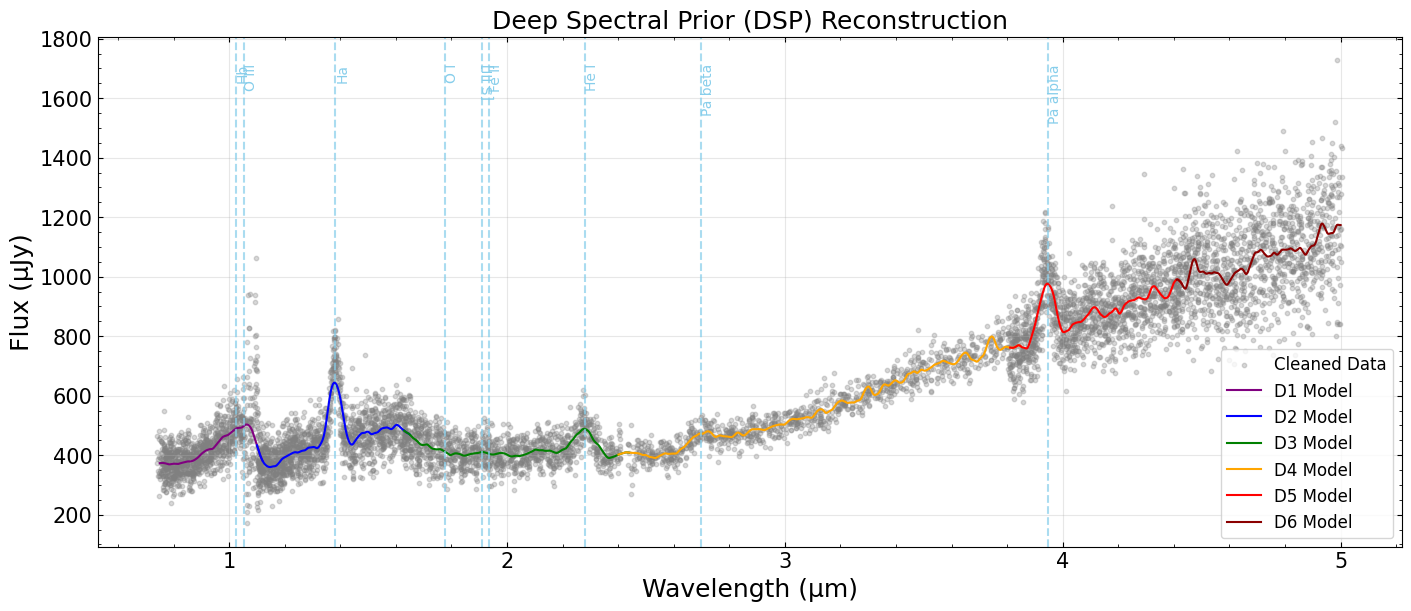

In [5]:
# Emission line list for reference
EL_LIST = {
    "Hb": 4861,
    "O III": 5007,
    "Ha": 6563,
    "O I": 8446,
    "[S III]": 9069,
    "Fe II": 9202,
    "Pa alpha": 18756,
    "Pa beta": 12818,
    "He I": 10830,
}
redshift = 1.104663746549563

# Plot the full spectrum
fig, ax = plt.subplots(figsize=(14, 6))

# Plot CLEANED data points (iterate through bands)
# We use the band_data_dict loaded earlier
colors = {"D1": "purple", "D2": "blue", "D3": "green", "D4": "orange", "D5": "red", "D6": "darkred"}

for band, bd in band_data_dict.items():
    ax.scatter(
        bd.wavelength_center,
        bd.flux,
        color="gray",
        alpha=0.3,
        s=10,
        label="Cleaned Data" if band == "D1" else None,  # Label only once
    )

# Plot reconstructed bands
# Since DIP produces a global spectrum, the band results are just slices of it
for band in ["D1", "D2", "D3", "D4", "D5", "D6"]:
    if band in result_dip.band_results:
        res = result_dip.band_results[band]
        ax.plot(res.wavelength, res.flux, color=colors.get(band, "black"), linewidth=1.5, label=f"{band} Model")

# Add emission line markers
for line, wl_rest in EL_LIST.items():
    wl_obs = wl_rest * (1 + redshift) / 1e4  # Convert to microns
    if 0.75 <= wl_obs <= 5.0:
        ax.axvline(wl_obs, color="skyblue", linestyle="--", alpha=0.7)
        ax.text(wl_obs, ax.get_ylim()[1] * 0.95, line, rotation=90, color="skyblue", fontsize=10, ha='left', va='top')

ax.set_xlabel("Wavelength (µm)")
ax.set_ylabel("Flux (µJy)")
ax.set_title("Deep Spectral Prior (DSP) Reconstruction")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
# ax.set_ylim(0, 1500)

# plt.tight_layout()
plt.show()

## 6. Quality Metrics
Check the goodness-of-fit for each band.

In [6]:
print("DIP Quality Metrics (Reduced Chi-Squared):")
print("=" * 50)
for band, res in result_dip.band_results.items():
    metrics = res.validation_metrics
    print(f"global: χ²_ν = {metrics.chi_squared_reduced:.3f}")
    print(f"     Weighted Residuals: mean={metrics.weighted_residual_mean:.3f}, std={metrics.weighted_residual_std:.3f}")
    break # All bands have the same global fit metrics

DIP Quality Metrics (Reduced Chi-Squared):
global: χ²_ν = 2.541
     Weighted Residuals: mean=0.012, std=1.234


## 7. Save Results
Save the reconstruction to CSV and YAML.

In [7]:
csv_path, yaml_path = result_dip.save_all(output_dir)

print(f"Saved DIP results:")
print(f"  Spectrum CSV: {csv_path}")
print(f"  Metadata YAML: {yaml_path}")

Saved DIP results:
  Spectrum CSV: demo_data/spec_refine/dip_output/sed_reconstruction.csv
  Metadata YAML: demo_data/spec_refine/dip_output/sed_metadata.yaml


/Users/wenke/data/20250805SPHEREX/spxquery/.venv/lib/python3.14/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wenke/data/20250805SPHEREX/spxquery/.venv/lib/python3.14/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
